In [1]:
from typing import Union
from itertools import product
import numpy as np
from numba import njit, prange
from src.utils import poly_eval

In [2]:
def allsequences(n:int, terms:list=[1,-1])->np.ndarray:
    """
    Generates from the elements in `terms` the list of all sequences 
    of length `n`.

    Parameters
    ----------
    n: int
        Length of sequences
    terms: list
        Optional. Elements with which to construct the sequences.
        Default is `[1,-1]`.

    Return
    ------
    numpy.array
        List of sequences.

    Example
    -------
    >>> seq = allsequences(2)
    >>> print(seq)
    array([[ 1, 1],
           [ 1,-1],
           [-1, 1],
           [-1,-1]])
    """
    lst = np.array([seq for seq in product(terms, repeat=n)])
    return lst

@njit
def check(param:complex,sequences:list)->list:
    RAD = (1-np.abs(param))**(-1)
    return [s for s in sequences if np.abs(1+param*poly_eval(param,s))<1e-14+RAD*np.abs(param**(len(s)+1))]

In [3]:
def solomyak_algorithm(param:complex, depth:int=3)->list:
    """
    Implementation of a variant of Solomyak2005 algorithm
    to check that for a given parameter c all power series
    in F_c have a certain initial part. 
    """
    sequences = allsequences(depth,[1,0,-1])
    seq_flip = np.array([np.flip(s) for s in sequences])
    results = check(param, seq_flip)
    return results #np.array([sequences[i] for i in results],dtype=np.int32)

In [ ]:
solomyak_algorithm(0.5847168010308 + 0.2733728277929043779576*1j,10)

Transform a sequence in the alphabet `+,0,-` into `1,0,-1`.
Check that all elements in the result of `solomyak_algorithm` start with the initial given sequence.

In [4]:
def convert(sequence:str)->list:
    result = np.array([],dtype=np.int32)
    for s in sequence:
        if s=='+':
            result = np.append(result,1)
        elif s=='-':
            result = np.append(result,-1)
        else:
            result = np.append(result,0)
    return result

@njit
def compare(sequence:list, s_list:np.array)->bool:
    result = np.zeros(len(s_list),dtype=np.bool_)
    n = len(sequence)
    for i,s in enumerate(s_list):
        if (s[:n]==sequence).all():
            result[i]=True
        else:
            return False
    return np.all(result)

In [27]:
from src.angles import Angle
from math import ceil


def preperiodic_angles(per,max_pre_rng=2,*, b_num=None, b_den=None):
    """Compute all the rational angles that under the doubling map
    are preperiodic with given period (`per`) and preperiod up to
    `max_pre_rng`.
    
    If `b_num` and `b_den` are given, compute all the preperiodic angles
    in the interval `[b_num/b_den, (b_num+1)/b_den]`."""
    if b_num is None:
        return [
            [2*k+1,(2**per-1)*2**(n)] 
            for n in prange(1,max_pre_rng) for k in prange(0,ceil(((2**per-1)*2**(n-1)-1)/2))
        ]
    else:
        return [
            [2*k+1,(2**per-1)*2**(n)] 
            for n in prange(1,max_pre_rng) for k in prange(0,ceil(((2**per-1)*2**(n-1)-1)/2))
            if b_den*(2*k+1) > b_num*(2**per-1)*2**(n) and b_den*(2*k+1) < (b_num+1)*(2**per-1)*2**(n)
        ]

angle_list = preperiodic_angles(3,7,b_num=1,b_den=7)
angle_list

[[3, 14],
 [5, 28],
 [7, 28],
 [9, 56],
 [11, 56],
 [13, 56],
 [15, 56],
 [17, 112],
 [19, 112],
 [21, 112],
 [23, 112],
 [25, 112],
 [27, 112],
 [29, 112],
 [31, 112],
 [33, 224],
 [35, 224],
 [37, 224],
 [39, 224],
 [41, 224],
 [43, 224],
 [45, 224],
 [47, 224],
 [49, 224],
 [51, 224],
 [53, 224],
 [55, 224],
 [57, 224],
 [59, 224],
 [61, 224],
 [63, 224],
 [65, 448],
 [67, 448],
 [69, 448],
 [71, 448],
 [73, 448],
 [75, 448],
 [77, 448],
 [79, 448],
 [81, 448],
 [83, 448],
 [85, 448],
 [87, 448],
 [89, 448],
 [91, 448],
 [93, 448],
 [95, 448],
 [97, 448],
 [99, 448],
 [101, 448],
 [103, 448],
 [105, 448],
 [107, 448],
 [109, 448],
 [111, 448],
 [113, 448],
 [115, 448],
 [117, 448],
 [119, 448],
 [121, 448],
 [123, 448],
 [125, 448],
 [127, 448]]

In [28]:
from sympy.sets.conditionset import ConditionSet

working_per3 = []
for ang in angle_list:
    theta = Angle(ang[0],ang[1])
    theta.assoc_lambda()
    if type(theta.lam)==ConditionSet:
        continue
    lam = complex(theta.lam) # need to cast from <class 'sympy.core.add.Add'>
    lam = lam if lam.imag>0 else lam.conjugate() # always want positive imaginary part

    print(f"{theta}\nitin = {theta.itin}")
    seq = convert(theta.itin)
    print(f"{seq = }")
    print(f"lambda = {lam}")
    if not np.abs(lam)<1e-13 and lam.imag>0:
        res = solomyak_algorithm(lam,len(seq))
        print(f"{res = }\n")
        if res:
            onBdd = compare(seq[1:],res)
            print(f"\t\t\t\t{onBdd}\n\n")
            if onBdd: working_per3.append(theta)
        else:
            print("\t\t\t\tempty\n\n")
    else:
        print("\n\t\t\t\ttry another\n\n")

3/14
itin = +-+++---
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.3668759642641294+0.5202594388652009j)
res = [array([-1,  1,  1,  1, -1, -1, -1,  1])]

				True


5/28
itin = +-++---++
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.2901245624146316+0.5856062443322586j)
res = [array([-1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  1,  0])]

				True


7/28
itin = +-+
seq = array([ 1, -1,  1])
lambda = (0.5+0.5j)
res = [array([-1,  1,  1]), array([0, 0, 1]), array([-1,  0,  1]), array([ 0, -1,  1]), array([-1, -1,  1]), array([-1,  1,  0]), array([-1,  0,  0]), array([-1,  1, -1])]

				False


2023-06-28 13:44:01,605 - ERROR   : 9/56; Could not find any viable solution inside the disk of radius 2^(-0.5)
9/56
itin = +-++-+-+-+
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 13:44:01,674 - ERROR   : 11/56; Could not find any viable solution inside the disk of radius 2^(-0.5)
11/56
itin 

res = [array([-1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1,  1, -1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  0,  1, -1, -1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1, -1,  0,  1, -1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  0, -1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  

59/224
itin = +-+++-+++---
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = -0j

				try another


2023-06-28 13:44:20,677 - ERROR   : 61/224; Could not find any viable solution inside the disk of radius 2^(-0.5)
61/224
itin = +-++-++---++
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = -0j

				try another


2023-06-28 13:44:20,814 - ERROR   : 63/224; Could not find any viable solution inside the disk of radius 2^(-0.5)
63/224
itin = +-++-+
seq = array([ 1, -1,  1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 13:44:24,684 - ERROR   : 65/448; Could not find any viable solution inside the disk of radius 2^(-0.5)
65/448
itin = +-++-++-+-+-+
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 13:44:24,827 - ERROR   : 67/448; Could not find any viable solution inside the disk of radius 2^(-0.5)
67/448
itin = +-++-++-+-+-+
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, 

83/448
itin = +-++-----+++-
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1])
lambda = (0.3433634736235668+0.58460407314395j)
res = [array([-1,  1,  1,  0, -1, -1,  1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0,  0,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1, -1,  1, -1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  0,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1, -1,  1, -1, -1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0,  0,  0,  1,  0,  1]), array([-1,  1,  1,  0, -1, -1,  0,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  0, -1,  0,  0,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  0, -1, -1,  1, -1,  1, -1,  0,  0,  1]), array([-1,  1,  1,  0, -1,  0,  0,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0, -1,  1, -1,  0,  1]), array([-1,  1,  1,  0, -1,  0,  0,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  0, -1, -1,  1, -1,  1, -1, -1,  0,  1]

2023-06-28 13:45:22,231 - ERROR   : 87/448; Could not find any viable solution inside the disk of radius 2^(-0.5)
87/448
itin = +-++-+-+++---
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = -0j

				try another


89/448
itin = +-++-+--+++--
seq = array([ 1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.37878728273397716+0.591207404380816j)
res = [array([-1,  1,  1,  0, -1,  0,  0, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1,  1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0, -1,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1,  1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  0, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0, -1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1,  0,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0, -1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  0, -1, -1, -1,  1,  1,  1]),

91/448
itin = +-+++-+
seq = array([ 1, -1,  1,  1,  1, -1,  1])
lambda = (0.39466688491383073+0.5863538905269345j)
res = [array([-1,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  0,  1, -1,  1]), array([-1,  1,  1,  1,  0, -1,  1]), array([-1,  1,  1,  0,  0, -1,  1]), array([-1,  1,  1,  1, -1, -1,  1]), array([-1,  1,  0,  1, -1, -1,  1]), array([-1,  1,  1,  0,  0,  1,  0]), array([-1,  1,  1,  1, -1,  1,  0]), array([-1,  1,  1,  0, -1,  1,  0]), array([-1,  1,  1,  0,  0,  0,  0]), array([-1,  1,  1,  1, -1,  0,  0]), array([-1,  1,  1,  0, -1,  0,  0]), array([-1,  1,  1,  0,  1, -1,  0]), array([-1,  1,  1, -1,  1, -1,  0]), array([-1,  1,  1,  0,  0, -1,  0]), array([-1,  1,  0,  1, -1, -1,  0]), array([-1,  1,  1,  0, -1, -1,  0]), array([-1,  1,  1,  0,  0,  1, -1]), array([-1,  1,  1,  1, -1,  1, -1]), array([-1,  1,  1,  0, -1, 

101/448
itin = +-+++-+---+++
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = (0.4254947115758749+0.5174745462743507j)
res = [array([-1,  1,  1,  1,  0, -1,  1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1, -1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1, -1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  0, -1,  0, -1, -1, -1, -1,  0,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1, -1,  0,  1, -1, 

res = [array([-1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0,  0, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1, -1,  0,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1, -1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0,  1, -1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  0,  1]), array([-1,  1,  1

115/448
itin = +-++++-+++---
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.4412315983615806+0.5443492129819332j)
res = [array([-1,  1,  1,  0,  1,  0, -1,  1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1,  0,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  0,  0, -1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1,  0,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1,  0, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  0,  0,  0, -1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1,  0, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1,  0, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1,  1, -1, -1,  1,  1, 

2023-06-28 13:47:21,513 - ERROR   : 117/448; Could not find any viable solution inside the disk of radius 2^(-0.5)
117/448
itin = +-+++-++---++
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = -0j

				try another


119/448
itin = +-+++-+
seq = array([ 1, -1,  1,  1,  1, -1,  1])
lambda = (0.39466688491383073+0.5863538905269345j)
res = [array([-1,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  0,  1, -1,  1]), array([-1,  1,  1,  1,  0, -1,  1]), array([-1,  1,  1,  0,  0, -1,  1]), array([-1,  1,  1,  1, -1, -1,  1]), array([-1,  1,  0,  1, -1, -1,  1]), array([-1,  1,  1,  0,  0,  1,  0]), array([-1,  1,  1,  1, -1,  1,  0]), array([-1,  1,  1,  0, -1,  1,  0]), array([-1,  1,  1,  0,  0,  0,  0]), array([-1,  1,  1,  1, -1,  0,  0]), array([-1,  1,  1,  0, -1,  0,  0]), array([-1,  1,  1,  0,  1, -1,  0]), array(

In [31]:
[(a,a.ks) for a in working_per3]

[(Angle(3,14), '1100'),
 (Angle(5,28), '11010'),
 (Angle(13,56), '110001'),
 (Angle(19,112), '1101010'),
 (Angle(27,112), '1100001'),
 (Angle(41,224), '11010001'),
 (Angle(47,224), '11001010'),
 (Angle(75,448), '110101010'),
 (Angle(97,448), '110010001')]

In [33]:
(len(angle_list),angle_list[-1]) # preperiodic_angles(3,7,b_num=1,b_den=7)

(63, [127, 448])

In [34]:
angle_list = preperiodic_angles(3,11,b_num=1,b_den=7)

In [35]:
(len(angle_list),angle_list[-1]) # preperiodic_angles(3,11,b_num=1,b_den=7)

(1023, [2047, 7168])

In [37]:
angle_list[:63]

[[3, 14],
 [5, 28],
 [7, 28],
 [9, 56],
 [11, 56],
 [13, 56],
 [15, 56],
 [17, 112],
 [19, 112],
 [21, 112],
 [23, 112],
 [25, 112],
 [27, 112],
 [29, 112],
 [31, 112],
 [33, 224],
 [35, 224],
 [37, 224],
 [39, 224],
 [41, 224],
 [43, 224],
 [45, 224],
 [47, 224],
 [49, 224],
 [51, 224],
 [53, 224],
 [55, 224],
 [57, 224],
 [59, 224],
 [61, 224],
 [63, 224],
 [65, 448],
 [67, 448],
 [69, 448],
 [71, 448],
 [73, 448],
 [75, 448],
 [77, 448],
 [79, 448],
 [81, 448],
 [83, 448],
 [85, 448],
 [87, 448],
 [89, 448],
 [91, 448],
 [93, 448],
 [95, 448],
 [97, 448],
 [99, 448],
 [101, 448],
 [103, 448],
 [105, 448],
 [107, 448],
 [109, 448],
 [111, 448],
 [113, 448],
 [115, 448],
 [117, 448],
 [119, 448],
 [121, 448],
 [123, 448],
 [125, 448],
 [127, 448]]

In [ ]:

working_per3 = []
for ang in angle_list[63:]:
    theta = Angle(ang[0],ang[1])
    theta.assoc_lambda()
    if type(theta.lam)==ConditionSet:
        continue
    lam = complex(theta.lam) # need to cast from <class 'sympy.core.add.Add'>
    lam = lam if lam.imag>0 else lam.conjugate() # always want positive imaginary part

    print(f"{theta}\nitin = {theta.itin}")
    seq = convert(theta.itin)
    print(f"{seq = }")
    print(f"lambda = {lam}")
    if not np.abs(lam)<1e-13 and lam.imag>0:
        res = solomyak_algorithm(lam,len(seq))
        print(f"{res = }\n")
        if res:
            onBdd = compare(seq[1:],res)
            print(f"\t\t\t\t{onBdd}\n\n")
            if onBdd: working_per3.append(theta)
        else:
            print("\t\t\t\tempty\n\n")
    else:
        print("\n\t\t\t\ttry another\n\n")

2023-06-28 13:54:39,311 - ERROR   : 129/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
129/896
itin = +-++-++-+++---
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = -0j

				try another


2023-06-28 13:54:49,657 - ERROR   : 131/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
131/896
itin = +-++-++--+++--
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = -0j

				try another


2023-06-28 13:54:50,187 - ERROR   : 133/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
133/896
itin = +-++-++-
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1])
lambda = -0j

				try another


2023-06-28 13:54:54,611 - ERROR   : 135/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
135/896
itin = +-++-+++-+-+-+
seq = array([ 1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 13:54:54,826 - ERROR   : 137/89

res = [array([ 0,  1,  1,  1, -1, -1,  1,  1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  0, -1,  0,  1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1,  1,  1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  0, -1,  0,  0,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1,  1,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1, -1,  0,  1, -1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1,  1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  0, -1, -1, -1,  1,  1,  0, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0,  1,  1,  0,  1,  1]), array([ 0,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  0, -1, -1,  1,  0,  1,  1]), array([ 0,  1,  1,  1, -1, -1,  1,  1,  0,  1, -1,  0,  1,  1]), array([-1,  1,  1,

153/896
itin = +-++--++++---+
seq = array([ 1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.2721445413225543+0.6154620380753975j)
res = [array([-1,  1,  1, -1, -1,  0,  1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0, -1, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1,  0,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1, -1,  1,  0,  0,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  0,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1, -1,  1,  1, -1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1, -1,  1,  0, -1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1,  0,  1,  1,  1,  0]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1,  0,  1,  0,  1,  0]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1,  0,  0,  1,  0,  0]), array([-1,  1,  1, -1, -1,  0,  1,  1, -1, -1,  1,  0,  0,  0])

157/896
itin = +-++---+---+++
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = (0.2829546786682021+0.618967426718272j)
res = [array([-1,  1,  1, -1, -1,  0,  1,  0,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  1, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  0, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1, -1, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  1, -1,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1,  0,  0,  1, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0, -1,  0,  0,  1]),

res = [array([-1,  1,  1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0,  0,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0,  0,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0, -1,  0, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0, -1, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1, -1, -1, -1,  0,  0,  1,  1,  1,  0,  0,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  0,  0,  0,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0, -1, -1,  0,  0,  1]), array([-1,  1,  1, -1, -1, -1,  0,  0,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1,  0,  1, -1,  0,  1]), array([-1,  1,  1,

171/896
itin = +-++--+-+++---
seq = array([ 1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.319006737865944+0.620303943008887j)
res = [array([-1,  1,  1, -1, -1, -1,  0, -1, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  0,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0, -1, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  1,  1,  1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  1,  0,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  0,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  1,  0,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1, -1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  0, -1, -1, -1,  1,  1,  1]), 

2023-06-28 13:58:34,054 - ERROR   : 173/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
173/896
itin = +-++--+--+++--
seq = array([ 1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = -0j

				try another


2023-06-28 13:58:34,408 - ERROR   : 175/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
175/896
itin = +-++-+-+
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 13:58:39,134 - ERROR   : 177/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
177/896
itin = +-++-+--+-+-+-
seq = array([ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 13:58:39,284 - ERROR   : 179/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
179/896
itin = +-++-+--+-+-+-
seq = array([ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


181/896
itin = +-+++-++++---+
seq = array(

2023-06-28 13:59:05,852 - ERROR   : 183/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
183/896
itin = +-+++-++-+-+-+
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


185/896
itin = +-+++--+---+++
seq = array([ 1, -1,  1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = (0.40295393901162785+0.5454773137139362j)
res = [array([-1,  1,  1,  0,  0, -1, -1, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  0,  0,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  1,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1, -1, -1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  0, -1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  0, -1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1, -1, -1,  0,  1,  0,  0,  1,  1]), array([-1,

187/896
itin = +-+++--++---++
seq = array([ 1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.3674213698405464+0.5622637028559431j)
res = [array([-1,  1,  1,  0, -1, -1, -1,  0, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1, -1,  0, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0,  0, -1,  0,  1,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0, -1,  0, -1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  1,  1,  1,  0, -1, -1,  1,  1]), array([-1,  1,  1,  0, -1, -1, -1,  0, -1,  1,  0,  1,  0,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0,  0, -1,  1,  0,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0, -1,  0,  0,  0,  1]), array([-1,  1,  1,  0, -1, -1, -1, -1,  0, -1,  0, -1,  0,  1]), array([-1,  1,  1,  1, -1,  0,  1,  1,  1,  0, -1, -1,  0,  1]), array([-1,  1,  1,  0, -1, -1, -1,  0, -1,  1,  0,  1, -1,  1])

195/896
itin = +-+++-----+++-
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1])
lambda = (0.3888862037323204+0.5101870741762716j)
res = [array([-1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1])]

				True


197/896
itin = +-+++---+-+-+-
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.37719071791693765+0.5241997054645631j)
res = [array([-1,  1,  1,  1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1, -1, -1,  0, -1,  1,  1, -1, -1,  0,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1, -1,  0,  1, -1, -1,  1]), array([-1,  1,  1,  1, 

201/896
itin = +-+++-+--+++--
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.40983293799539083+0.5251279253236245j)
res = [array([-1,  1,  1,  1, -1,  0, -1, -1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  0,  1, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0, -1, -1, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1,  0, -1, -1, -1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  0, -1,  0,  0,  0,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1, -1,  0, -1, -1, -1,  0,  0, -1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  0,  0,  0, -1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1,  1,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  0,  1, -1,  1,  0,  1,  0,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1,  0, -1, -1, -1,  0, -1,  1,  0,  1]

res = [array([-1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1, -1,  0, -1,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1,  0, -1,  1,  1, -1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  1, -1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  0,  1, -1, -1,  1]), array([-1,  1,  1,  1,  1, -1,  0, -1,  1,  1,  0, -1, -1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  1,  1,  0]), array([-1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  0,  1,  0]), array([-1,  1,  1,

215/896
itin = +-+++++--+++--
seq = array([ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.4490752132262482+0.47714322612311466j)
res = [array([-1,  1,  1,  1,  1,  0, -1,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0, -1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0, -1, -1,  0,  1,  0,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  0,  1, -1,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1,  0, -1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0, -1, -1,  0,  1,  1,  0]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  1,  0]), array([-1,  1,  1,  1,  1,  0, -1,  0, -1, -1,  0,  0,  1,  0]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1, -1,  1,  0]

res = [array([-1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0, -1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  0, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  0,  1]), array([-1,  1,  1,

res = [array([-1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0, -1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  0, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  0,  1]), array([-1,  1,  1,

229/896
itin = +-++++-++---++
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.4673359630885229+0.510702336234121j)
res = [array([-1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1, -1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0,  1,  0, -1, -1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1,  0, -1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  1, -1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0,  1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1,  0, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  1,  0,  1,  1,  0,  1,  1]),

231/896
itin = +-++++-+
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1])
lambda = (0.4314983599820929+0.5182207329466472j)
res = [array([-1,  1,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  0,  1, -1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1]), array([-1,  1,  1,  1,  0,  0,  1,  0]), array([-1,  1,  1,  1,  1, -1,  1,  0]), array([-1,  1,  1,  1,  0, -1,  1,  0]), array([-1,  1,  1,  1,  0,  0,  0,  0]), array([-1,  1,  1,  1,  1, -1,  0,  0]), array([-1,  1,  1,  1,  0,  1, -1,  0]), array([-1,  1,  1,  1, -1,  1, -1,  0]), array([-1,  1,  1,  1,  0,  0, -1,  0]), array([-1,  1,  1,  0,  1, -1, -1,  0]), array([-1,  1,  1,  1,  0,  0,  1, -1]), array([-1,  1,  1,  1,  0, -1,  1, -1]), array([-1,  1,  1,  1,  0,  0,  0, -1]), array([-1,  1,  1,  1,  0, -1,  0, -1]), array([-1,  1,  1,  1, -1,  1, -1, -1]), array([-1,  1,  1,  1,  0,  0, -1, -1]), array([-1,  1,  1,  0,  1, -1, -1, -1])]

				False



2023-06-28 14:05:59,482 - ERROR   : 239/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
239/896
itin = +-++-+--+-+-+-
seq = array([ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 14:05:59,938 - ERROR   : 241/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
241/896
itin = +-++-+-+---+++
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = -0j

				try another


2023-06-28 14:06:00,512 - ERROR   : 243/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
243/896
itin = +-++-++--+++--
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = -0j

				try another


2023-06-28 14:06:00,987 - ERROR   : 245/896; Could not find any viable solution inside the disk of radius 2^(-0.5)
245/896
itin = +-++-++-
seq = array([ 1, -1,  1,  1, -1,  1,  1, -1])
lambda = -0j

				try another


2023-06-28 14:06:01,478 - ERROR   : 247/89

303/1792
itin = +-++--+++-+-+-+
seq = array([ 1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.2612925817256535+0.6292200160443475j)
res = [array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  0,  0, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  0, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  0,  1,  0,  1]), array([-1

307/1792
itin = +-++--+++++---+
seq = array([ 1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.2822040221166455+0.6238718614019423j)
res = [array([-1,  1,  1, -1, -1,  1,  0,  1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  0, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0, -1,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  0, -1, -1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  0, -1, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0,  0,  0,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1, -1, -1,  1, -1,  1,  1]), array([-1

res = [array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  0,  0, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  0,  0, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  0,  1,  0,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1]), array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  0,  0,  1]), array([-1,  1,  1, -1, -1, 

313/1792
itin = +-++---+--+++--
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.29643081642272534+0.6320134878449439j)
res = [array([-1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1, -1,  1,  1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0,  0,  1,  1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1, -1,  1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  1,  1,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0,  0,  1,  1,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0, -1,  0, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1, -1,  1,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  0,  1, -1,  1,  1,  1]), array([-

315/1792
itin = +-++---+-
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1, -1])
lambda = (0.291309285801537+0.612726553215384j)
res = [array([-1,  1,  1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  0,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  1]), array([-1,  1,  1, -1, -1, -1,  1, -1,  1]), array([-1,  1,  1, -1, -1,  0,  1,  1,  0]), array([-1,  1,  1, -1, -1,  0,  0,  1,  0]), array([-1,  1,  1, -1, -1,  0,  1,  0,  0]), array([-1,  1,  1, -1, -1, -1,  1,  0,  0]), array([-1,  1,  1, -1, -1,  0,  0,  0,  0]), array([-1,  1,  1, -1, -1, -1,  1, -1,  0]), array([-1,  1,  1, -1, -1,  0,  0,  1, -1]), array([-1,  1,  1, -1, -1, -1,  1,  0, -1]), array([-1,  1,  1, -1, -1, -1,  0,  0, -1]), array([-1,  1,  1, -1, -1, -1,  1, -1, -1])]

				False


317/1792
itin = +-++---++-+-+-+
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.28998080768598233+

321/1792
itin = +-++---++++---+
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.29843363040912885+0.5862532679370002j)
res = [array([-1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1])]

				True


323/1792
itin = +-++---++-+-+-+
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.28998080768598233+0.5982929846208883j)
res = [array([-1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  0,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  0,  0, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  0,  0, -1, -1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  0,  1]), array([-1,  1,  1, -1, -1, -1,  1,  0,  0, -1, -1,  0,  1,  0,  1]), array([-1,  1,  1, -1, -1, -1,  1,  1,  0,  0,  1,  1,  0,  0,  1]), array([-1,  1,  1, -1, -1, -1,  1,  1, 

327/1792
itin = +-++----++---++
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.3108089770836816+0.5804505956341599j)
res = [array([-1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  0])]

				True


329/1792
itin = +-++----+
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1,  1])
lambda = (0.32125730821710907+0.5842085751811984j)
res = [array([-1,  1,  1, -1, -1, -1, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  1]), array([-1,  1,  1, -1, -1, -1, -1,  1,  0]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0]), array([-1,  1,  1,  0, -1, -1,  1,  1, -1]), array([-1,  1,  1, -1, -1, -1, -1,  1, -1])]

				False


331/1792
itin = +-++-----+-+-+-
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.332534226289736+0.5953415227585503j)
res = [array([-1,  1,  1, -1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0, 

res = [array([-1,  1,  1, -1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0, -1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1, -1,  0,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  0,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  0,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  0,  1, -1, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  0,  1, -1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  0, -1, 

335/1792
itin = +-++-------+++-
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1])
lambda = (0.32480418808392825+0.6274983819423473j)
res = [array([-1,  1,  1, -1,  0, -1,  1,  0,  1,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1, -1,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  0, -1, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1, -1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1, -1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  1,  1,  0,  1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  1, -1,  1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1, -1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  0,  1, -1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  1,  1,  1,  0,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  1,  0,  0,  1,  0,  0,  1,  1,  1]), array([-

337/1792
itin = +-++-----+-+-+-
seq = array([ 1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.332534226289736+0.5953415227585503j)
res = [array([-1,  1,  1, -1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1, -1,  1,  0, -1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1, -1,  0,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  0,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1,  0,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  0,  1, -1, -1, -1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1, -1,  0,  0,  1,  1,  1, -1,  1,  1]), array([-1,

339/1792
itin = +-++---+-+++---
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.31660383763950595+0.6068217702142724j)
res = [array([-1,  1,  1, -1, -1, -1, -1,  0, -1, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0, -1,  0,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1, -1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  1,  1,  0,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0, -1,  0,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0, -1,  1,  1,  1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  1,  0,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0, -1,  0,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  0,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0, -1,  1,  1,  0,  1,  1,  0,  1,  1]), array([-1,  1,  1, -1, -1, -1,  0, -1,  1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  0, -1,  0,  1,  1, -1, -1, -1,  1,  0,  1,  1]), array([-

341/1792
itin = +-++---+--+++--
seq = array([ 1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.29643081642272534+0.6320134878449439j)
res = [array([-1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1, -1,  1,  1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1,  0,  0,  1,  1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1, -1,  1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  1, -1,  1,  1,  1,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1,  0,  0,  1,  1,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0, -1,  0, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1, -1, -1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1]), array([ 0,  1,  1,  1, -1, -1, -1,  1,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1, -1, -1,  0,  0,  0, -1,  0,  1, -1,  1,  1,  1]), array([-

2023-06-28 14:25:06,411 - ERROR   : 343/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
343/1792
itin = +-++--+-+
seq = array([ 1, -1,  1,  1, -1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 14:25:06,801 - ERROR   : 345/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
345/1792
itin = +-++--+--+-+-+-
seq = array([ 1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 14:25:07,289 - ERROR   : 347/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
347/1792
itin = +-++-+-++-+-+-+
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 14:25:18,349 - ERROR   : 349/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
349/1792
itin = +-++-+-++++---+
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = -0j

				try another


2023-06-28 14:

365/1792
itin = +-+++-+++-+-+-+
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 14:26:54,819 - ERROR   : 367/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
367/1792
itin = +-+++-+-+---+++
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = -0j

				try another


369/1792
itin = +-+++-+-++---++
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.3940057005439891+0.5619802127335164j)
res = [array([-1,  1,  1,  0,  0, -1, -1,  1, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  0,  1, -1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1, -1,  0,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1,  0, -1,  1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  1, -1,  1,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  0, -1, 

371/1792
itin = +-+++--+-
seq = array([ 1, -1,  1,  1,  1, -1, -1,  1, -1])
lambda = (0.38925862050260623+0.5501214897423257j)
res = [array([-1,  1,  1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  0,  0, -1, -1,  1,  1]), array([-1,  1,  1,  1, -1,  0,  1,  0,  1]), array([-1,  1,  1,  1, -1,  0,  0,  0,  1]), array([-1,  1,  1,  0,  0, -1, -1,  0,  1]), array([-1,  1,  1,  1, -1,  0,  1, -1,  1]), array([-1,  1,  1,  1, -1,  0,  0, -1,  1]), array([-1,  1,  1,  0,  0, -1,  0, -1,  1]), array([-1,  1,  1,  0,  0, -1, -1, -1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  1,  0]), array([-1,  1,  1,  1, -1,  0,  0,  1,  0]), array([-1,  1,  1,  1, -1,  0, -1,  1,  0]), array([-1,  1,  1,  0,  0, -1, -1,  1,  0]), array([-1,  1,  1,  1, -1,  0,  1,  0,  0]), array([-1,  1,  1,  1, -1, -1,  1,  0,  0]), array([-1,  1,  1,  1, -1,  0,  0,  0,  0]), array([-1,  1,  1,  0,  0, -1, -1,  0,  0]), array([-1, 

377/1792
itin = +-+++--++++---+
seq = array([ 1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.36048713460901793+0.5390784446508877j)
res = [array([-1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1])]

				True


379/1792
itin = +-+++--++-+-+-+
seq = array([ 1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.37123268934811865+0.5492378818926865j)
res = [array([-1,  1,  1,  1, -1, -1,  1,  1,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1,  0,  1, -1,  0,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  0,  0, -1, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1,  0,  0,  1,  1,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  0,  0,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  1,  1, 

383/1792
itin = +-+++---++---++
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.36773223270922367+0.5270076035010661j)
res = [array([-1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  0,  1,  1,  1,  1, -1, -1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  0,  1,  1,  1,  1, -1, -1, -1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  0])]

				False


385/1792
itin = +-+++---+
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.3718586800741364+0.5194111537479428j)
res = [array([-1,  1,  1,  1, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1,  0,  1]), array([-1,  1,  1,  1, -1, -1, -1,  1,  0])]

				False


387/1792
itin = +-+++----+-+-+-
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.3822260096340265+0.516186685542328j)
res = [array([-1,  1,  1,  1, -1, -1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1, -1, -1, 

395/1792
itin = +-+++---+---+++
seq = array([ 1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = (0.3799392819272637+0.5329584607175499j)
res = [array([-1,  1,  1,  1, -1, -1,  0,  0,  0,  0,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  0, -1,  1,  1,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1, -1,  0,  0, -1,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  0,  0,  0, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1, -1,  0, -1,  1,  1,  0,  0, -1, -1,  1,  1]), array([-1,  1,  1,  1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1,  0, -1,  1,  1,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  0,  0, -1,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  0,  0,  1]), array([-1,  1,  1,  1, -1, -1,  0,  0,  0, -1,  1, -1,  0,  0,  1]), array([-1

399/1792
itin = +-+++-+-+
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1,  1])
lambda = (0.4032035223045188+0.5428042913576371j)
res = [array([-1,  1,  1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0,  1]), array([-1,  1,  1,  1, -1,  0,  0,  0,  1]), array([-1,  1,  1,  1, -1,  1, -1,  0,  1]), array([-1,  1,  1,  1, -1,  0,  1, -1,  1]), array([-1,  1,  1,  1, -1,  0,  0, -1,  1]), array([-1,  1,  1,  0,  0, -1, -1, -1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  1,  0]), array([-1,  1,  1,  1,  0, -1,  0,  1,  0]), array([-1,  1,  1,  1, -1,  1, -1,  1,  0]), array([-1,  1,  1,  1,  0, -1,  1,  0,  0]), array([-1,  1,  1,  1, -1,  0,  0,  0,  0]), array([-1,  1,  1,  1, -1,  1, -1,  0,  0]), array([-1,  1,  1,  1, -1,  0, -1,  0,  0]), array([-1,  1,  1,  0,  0, -1, -1,  0,  0]), array([-1,  1,  1,  1, -1,  0,  1, -1,  0]), array([-1,  

res = [array([-1,  1,  1,  0,  1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1,  0,  1,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1,  0,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  1, -1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  0, 

405/1792
itin = +-++++-++++---+
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.42391064007735113+0.529641478597298j)
res = [array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1,  1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1,  0, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1,  1,  0,  1,  1]), array([-1

407/1792
itin = +-++++-++-+-+-+
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.4472839925736759+0.5169460204225035j)
res = [array([-1,  1,  1,  1,  1, -1,  1,  1,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  0, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0, -1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1,  0, -1,  1,  0,  1,  1]), array([-1

409/1792
itin = +-++++-+-+++---
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.4304006917389106+0.500992267506711j)
res = [array([-1,  1,  1,  1,  0,  0, -1, -1,  0, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1, -1, -1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  1, -1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  1, -1,  1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1, -1, -1,  0,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  0,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  1, -1,  1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  1,  0, -1,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  0,  0, -1, -1, -1,  0,  0, -1,  1,  0,  1]), array([-1,

413/1792
itin = +-++++--+
seq = array([ 1, -1,  1,  1,  1,  1, -1, -1,  1])
lambda = (0.41624201049223525+0.49462332854976493j)
res = [array([-1,  1,  1,  1,  1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1,  1,  0]), array([-1,  1,  1,  1,  0, -1, -1, -1, -1])]

				False


415/1792
itin = +-++++---+-+-+-
seq = array([ 1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.4222366901651422+0.4839135198887355j)
res = [array([-1,  1,  1,  1,  1, -1, -1, -1,  0,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1, -1,  0,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1, -1,  0,  1, -1, -1,  0,  0,  1]), array([-1,  1,  1,  1,  1, -1, -1,  0, -1,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  1,  1,

425/1792
itin = +-++++-+--+++--
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = (0.4395057204896051+0.4889978179550213j)
res = [array([-1,  1,  1,  1,  1, -1,  0, -1,  0, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1,  0,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0, -1,  0, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1,  0,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1,  0,  0,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  0,  1, -1, -1, -1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  0, -1,  0, -1, -1,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1,  0,  0,  0,  1,  0,  1]), array([-1,  1,  1,  1,  1, -1,  0,  0, -1, -1,  1,  1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  0,  1, -1, -1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  0, -1,  0,  1, -1,  1,  0, -1,  0,  1]), array([-1

res = [array([-1,  1,  1,  1,  1,  1, -1, -1,  1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0, -1,  1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  0,  1, -1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1, -1, -1,  0,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  1,  0, -1,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0, -1,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  0,  1, -1, -1,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0, -1,  1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  0, -1,  0,  1]), array([-1,  1,  1,  1,  1, 

437/1792
itin = +-+++++-+---+++
seq = array([ 1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = (0.47241356467265605+0.47037558773175653j)
res = [array([-1,  1,  1,  1,  1,  1,  0,  0, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0, -1,  1,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  1, -1,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  0,  0,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0, -1,  0,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  0,  0, -1,  0, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0, -1,  1,  0,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  1, -1,  0,  1,  1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  0,  0, -1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0, -1,  0,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  1,  1,  0, -1,  0,  0, -1,  0, -1,  0,  1]), array([

res = [array([-1,  0,  1,  1,  0, -1, -1,  0,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  0,  1,  1,  0, -1, -1, -1,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1,  0,  0,  0,  1,  1,  0,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0, -1,  1,  0,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1,  0, -1,  1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  0,  0,  0,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0,  0,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  1, -1,  0,  0,  0,  1,  1]), array([-1,  0,  1,  1,  0, 

2023-06-28 14:54:34,401 - ERROR   : 447/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
447/1792
itin = +-+++++++++---+
seq = array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = -0j

				try another


449/1792
itin = +-+++++++-+-+-+
seq = array([ 1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = (0.5052699309912431+0.4762419832526862j)
res = [array([-1,  0,  1,  1,  0, -1, -1,  0,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  0,  1,  1,  0, -1, -1, -1,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, -1, -1,  1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  1,  0,  1, -1,  0, -1,  1,  1,  1]), array([-1,  0,  1,  1,  0, -1, 

451/1792
itin = +-++++++-+++---
seq = array([ 1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = (0.4801675143637408+0.486915886089389j)
res = [array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0,  0, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0, -1,  0,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0, -1,  0, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0, -1,  0, -1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0, -1, -1,  1, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0, -1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  0,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  0, -1,  1, -1,  1,  1]), array([-1,

453/1792
itin = +-+++++-++---++
seq = array([ 1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1])
lambda = (0.47760360882310765+0.49008388843005946j)
res = [array([-1,  1,  1,  1,  0,  1,  0, -1, -1, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0, -1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1,  1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0,  1, -1, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1]), array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  1, -1,  0,  0,  1,  1]), array([

455/1792
itin = +-+++++-+
seq = array([ 1, -1,  1,  1,  1,  1,  1, -1,  1])
lambda = (0.4569129645672829+0.48913505662663015j)
res = [array([-1,  1,  1,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1,  1,  0,  0,  0,  1]), array([-1,  1,  1,  1,  1,  1, -1,  0,  1]), array([-1,  1,  1,  1,  1,  0,  1, -1,  1]), array([-1,  1,  1,  1,  1,  0,  0, -1,  1]), array([-1,  1,  1,  1,  1,  0,  0,  1,  0]), array([-1,  1,  1,  1,  1,  1, -1,  1,  0]), array([-1,  1,  1,  1,  1,  0, -1,  1,  0]), array([-1,  1,  1,  1,  1,  0,  0,  0,  0]), array([-1,  1,  1,  1,  1,  0,  1, -1,  0]), array([-1,  1,  1,  1,  1,  0,  0, -1,  0]), array([-1,  1,  1,  1,  0,  1, -1, -1,  0]), array([-1,  1,  1,  1,  1,  0,  0,  1, -1]), array([-1,  1,  1,  1,  1,  0, -1,  1, -1]), array([-1,  1,  1,  1,  1, -1,  1,  0, -1]), array([-1,  1,  1,  1,  1,  0,  0,  0, -1]), array([-1,  1,  1,  1,  0,  1, -1,  0, -1]), array([-1,  1,  1,  1,  1, -1,  1, -1, -1]), array([-1,  1,  1,  1,  0,  1,  0, -1, -1]), array([-1, 

res = [array([-1,  1,  1,  1,  1, -1,  1,  1,  0,  0,  1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  0, -1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0,  1, -1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  0, -1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0, -1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  1, -1,  0,  1,  0, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  1, -1,  1,  0,  1, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0, -1,  0, -1, -1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0, 

461/1792
itin = +-++++-++++---+
seq = array([ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1])
lambda = (0.42391064007735113+0.529641478597298j)
res = [array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  1, -1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0,  0, -1,  1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1,  1,  1, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  0,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0, -1,  1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0, -1,  1,  0, -1,  0, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1,  1,  0,  1,  1]), array([-1

463/1792
itin = +-+++-+--+-+-+-
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = (0.42079984356681893+0.532633628496918j)
res = [array([-1,  1,  1,  0,  1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1,  0,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  1, -1,  0,  1,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1, -1,  0,  0, -1,  0,  1,  1,  1]), array([-1,  1,  1,  1,  0,  0,  0,  0,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  0,  1, -1, -1,  1,  1,  1]), array([-1,  1,  1,  0,  1, -1, -1,  0,  1,  1,  1,  1,  0,  1,  1]), array([-1,  1,  1,  1,  0, -1,  1,  0, -1,  1,  0,  1,  0,  1,  1]), array([-1,  1,  1,  1, -1,  1, -1, -1,  1,  0,  0,  1,  0,  1,  1]), array([-1

2023-06-28 15:00:17,305 - ERROR   : 465/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
465/1792
itin = +-+++-+-+---+++
seq = array([ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = -0j

				try another


2023-06-28 15:00:29,303 - ERROR   : 467/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
467/1792
itin = +-+++-++--+++--
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = -0j

				try another


2023-06-28 15:00:29,624 - ERROR   : 469/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
469/1792
itin = +-+++-++-
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1, -1])
lambda = -0j

				try another


2023-06-28 15:00:30,121 - ERROR   : 471/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
471/1792
itin = +-+++-+++-+-+-+
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 15:

477/1792
itin = +-+++-+++-+-+-+
seq = array([ 1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1])
lambda = -0j

				try another


2023-06-28 15:01:14,189 - ERROR   : 479/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
479/1792
itin = +-++-+--+---+++
seq = array([ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1])
lambda = -0j

				try another


2023-06-28 15:01:14,809 - ERROR   : 481/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
481/1792
itin = +-++-+-+--+++--
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1])
lambda = -0j

				try another


2023-06-28 15:01:15,157 - ERROR   : 483/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
483/1792
itin = +-++-+-+-
seq = array([ 1, -1,  1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 15:01:15,583 - ERROR   : 485/1792; Could not find any viable solution inside the disk of radius 2^(-0.5)
485/1792
itin 

543/3584
itin = +-++-+++--+-+-+-
seq = array([ 1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 15:03:26,142 - ERROR   : 545/3584; Could not find any viable solution inside the disk of radius 2^(-0.5)
545/3584
itin = +-++-+++----+++-
seq = array([ 1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1, -1])
lambda = -0j

				try another


2023-06-28 15:03:26,355 - ERROR   : 547/3584; Could not find any viable solution inside the disk of radius 2^(-0.5)
547/3584
itin = +-++-+++--+-+-+-
seq = array([ 1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1])
lambda = -0j

				try another


2023-06-28 15:03:39,344 - ERROR   : 549/3584; Could not find any viable solution inside the disk of radius 2^(-0.5)
549/3584
itin = +-++-++++-+++---
seq = array([ 1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1])
lambda = -0j

				try another


2023-06-28 15:03:55,626 - ERROR   : 551/3584; Could not find any viable solution

Since the kernel died at 597/3584 here is the list of the working angle so far:

3,14

5,28

13,56

19,112

27,112

41,224

47,224

75,448

97,448

159,896

195,896

209,896

299,1792

321,1792

327,1792

377,1792

419,1792


Note that there should be also angle 55/224 (i checked with Mathematica) but solomyak_algorithm marked it as false as the comparison of the sequences fail at the last two terms.



here is a picture of all the above external angles landing on the Mandelbrot Set

![per3 window](../results/img/per3_window.png)

In [9]:
import matplotlib.pyplot as plt
from src.angles import Angle
from src.functions import core_entropy

per3_angles = [
    Angle(3,14),
    Angle(5,28),
    Angle(13,56),
    Angle(19,112),
    Angle(27,112),
    Angle(41,224),
    Angle(47,224),
    Angle(75,448),
    Angle(97,448),
    Angle(159,896),
    Angle(195,896),
    Angle(209,896),
    Angle(299,1792),
    Angle(321,1792),
    Angle(327,1792),
    Angle(377,1792),
    Angle(419,1792)
]
X_angles = [a.num/a.den for a in per3_angles]
working_core_entropy = [core_entropy(angle=a) for a in per3_angles]
    

In [6]:
def farey_sequence(n: int) -> list:
    """Return the nth Farey sequence."""
    (a, b, c, d) = (0, 1, 1, n)
    seq = []
    while (c <= n):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        if 2*a<b: seq.append([a, b])
    return seq

In [7]:
angles = farey_sequence(75)
X = [key[0]/key[1] for key in angles]
Y = [core_entropy(num=key[0],den=key[1]) for key in angles]

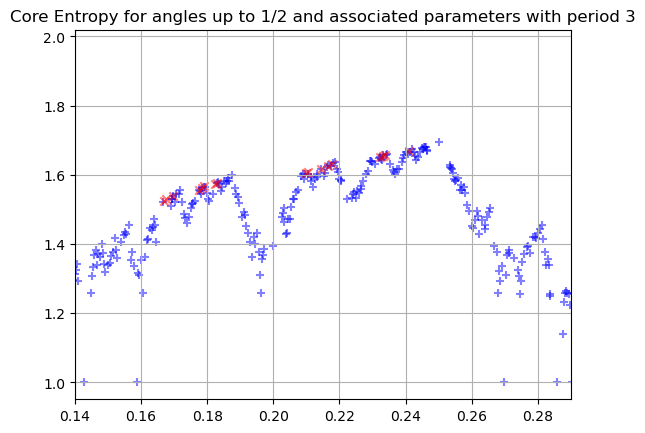

In [12]:
plt.scatter(X,Y,color="blue",alpha=0.5,marker='+')
plt.scatter(X_angles,working_core_entropy,color='red',alpha=0.5, marker='x')
plt.grid(True)
plt.title('Core Entropy for angles up to 1/2 and associated parameters with period 3')

plt.xlim(0.14,0.29)
# plt.ylim(1.6, 1.7)
plt.show()